# Análise exploratória de preços do Bitcoin (BTC/USDT)

Descrição resumida
- Script em Python para baixar OHLCV do par BTCUSDT da API da Binance, limpar e preparar os dados, calcular métricas/indicadores simples e gerar visualizações exploratórias.
- Etapas implementadas: coleta, limpeza, estatísticas descritivas, visualizações, correlação e feature engineering (médias móveis e volatilidade).

Dependências
- requests
- pandas
- numpy
- matplotlib
- seaborn

Instalação (exemplo)
```bash
pip install requests pandas numpy matplotlib seaborn
```

Principais funções/variáveis
- get_binance_ohlc(symbol="BTCUSDT", interval="1d", start=1493596800000, end=None)
    - Baixa candles (klines) da Binance e retorna DataFrame com colunas convertidas (datas e numéricos).
    - Parâmetro start em milissegundos (default começa em 2017).
- btc_df
    - DataFrame final filtrado para ["open_time", "open", "high", "low", "close", "volume"] e ordenado por data.
    - Colunas adicionadas: `return` (pct_change), `SMA_7`, `SMA_30`, `volatilidade_7d`.

Outputs / Visualizações geradas
- Série temporal do preço de fechamento.
- Gráfico de volume diário.
- Histograma + KDE da distribuição dos retornos diários.
- Heatmap da matriz de correlação entre variáveis.
- Gráfico do preço com médias móveis (7d e 30d).
- Estatísticas descritivas impressas e contagem de linhas analisadas.

Observações importantes
- Requer conexão com a internet e acesso à API pública da Binance.
- Atenção a limites de taxa da API; para séries longas pagine chamadas ou implemente cache.
- O start padrão (1493596800000) é em ms; ajuste para período desejado.
- Valores NaN aparecem nas primeiras linhas ao calcular médias móveis e retornos (comportamento esperado).

Melhorias sugeridas
- Salvar o DataFrame em CSV/Parquet para análises futuras e evitar múltiplas chamadas.
- Implementar tratamento de exceções mais robusto e retry/backoff para requisições.
- Adicionar normalização, features adicionais (RSI, MACD) e pipeline para modelagem/forecast.
- Incluir argumentos CLI ou widgets para escolher período, símbolo e intervalo.

Licença
- Livre para uso/ajuste (adapte conforme necessidade do projeto).

Valores nulos:
 open_time    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Resumo estatístico dos preços:
               open          high           low         close         volume  \
count    500.000000    500.000000    500.000000    500.000000     500.000000   
mean    7577.517160   7848.480860   7235.010820   7576.423500   27679.003079   
std     3042.091322   3224.699733   2748.115373   3042.629054   21213.907691   
min     3188.010000   3276.500000   2817.000000   3189.020000     228.108068   
25%     6134.300000   6269.405000   5872.507500   6136.160000    9337.499233   
50%     6753.730000   6895.255000   6610.500000   6755.480000   27136.217613   
75%     8687.957500   8991.737500   8284.500000   8687.942500   40332.102276   
max    19120.190000  19798.680000  18510.000000  19102.660000  117380.951590   

           return  
count  499.000000  
mean     0.000864  
std      0.048167  
min     -0.194974  
25%     -0.019680  
50%     

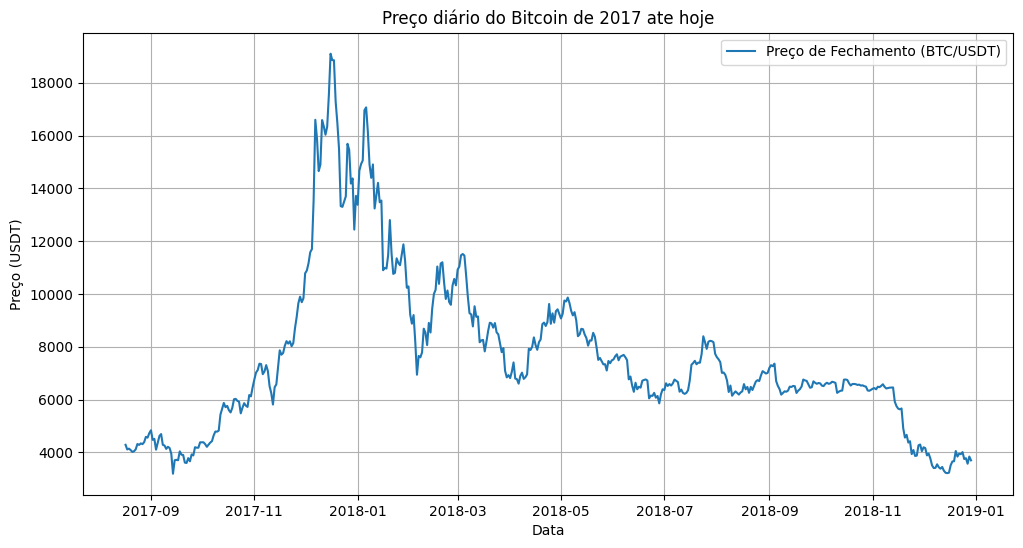

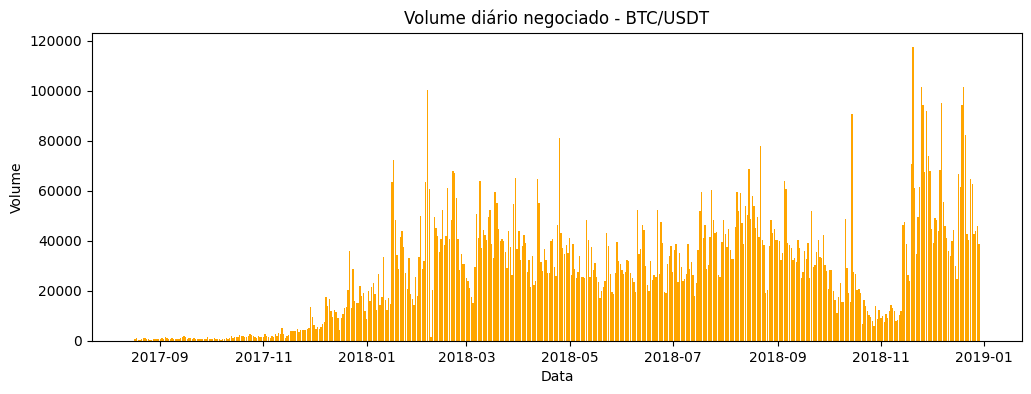

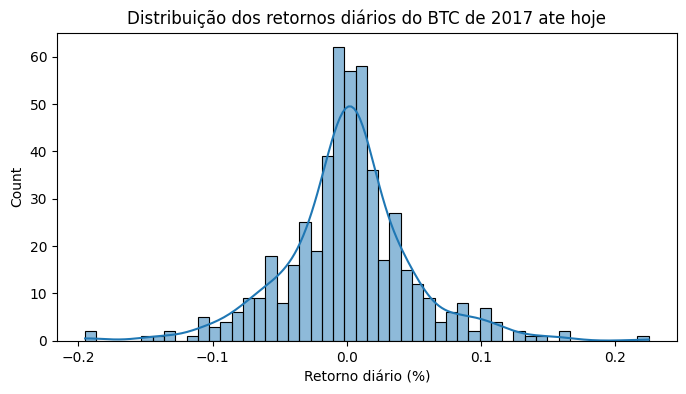

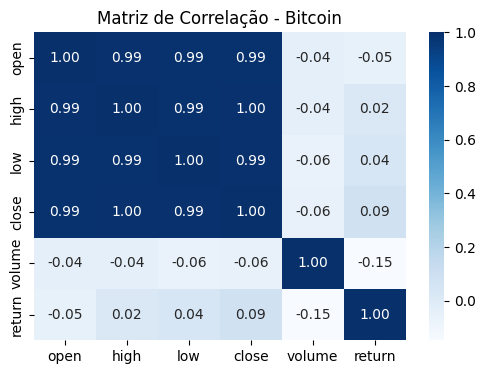

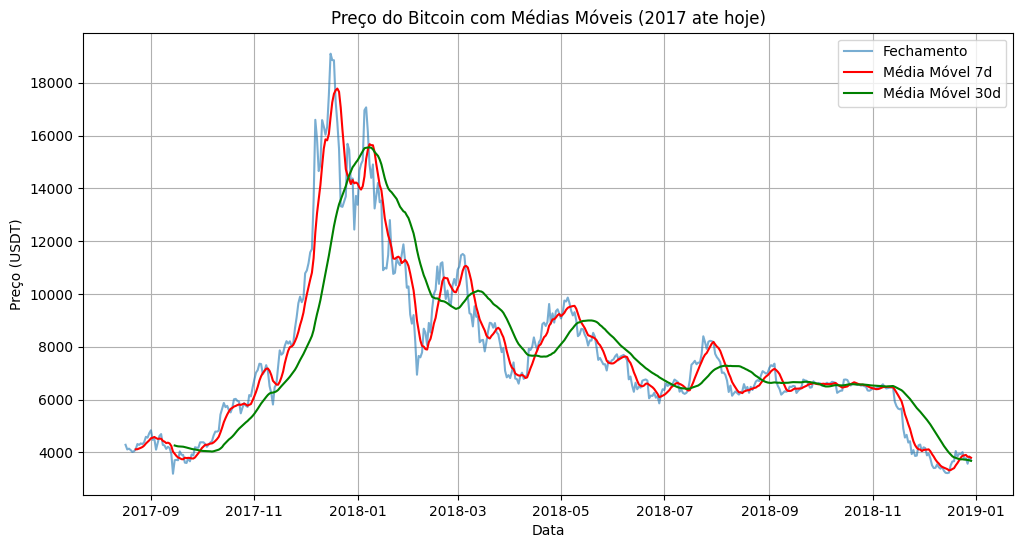

Análise exploratória concluída com sucesso!
Linhas analisadas: 500


,open_time,open,high,low,close,volume,return,SMA_7,SMA_30,volatilidade_7d
495,2018-12-25,4010.11,4020.00,3646.41,3745.79,62725.629432,-0.065424,3883.274286,3724.480333,0.056665
496,2018-12-26,3745.56,3837.15,3656.74,3777.74,42629.375817,0.008530,3899.777143,3721.665000,0.056667
497,2018-12-27,3777.74,3813.98,3535.00,3567.91,44097.392912,-0.055544,3830.961429,3711.421667,0.039401
498,2018-12-28,3567.89,3887.25,3540.04,3839.26,45964.304987,0.076053,3831.047143,3697.235333,0.049092
499,2018-12-29,3839.00,3892.00,3670.00,3695.32,38874.373903,-0.037492,3794.820000,3677.218000,0.049252


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# COLETA DE DADOS
# ==============================
def get_binance_ohlc(symbol="BTCUSDT", interval="1d",
                      start=1493596800000, end=None):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "startTime": start, "endTime": end}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "quote_volume", "num_trades",
            "taker_base_vol", "taker_quote_vol", "ignore"]

    df = pd.DataFrame(data, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df[["open", "high", "low", "close", "volume"]] = \
        df[["open", "high", "low", "close", "volume"]].astype(float)

    return df

# Baixar histórico do BTC para 2024
btc_df = get_binance_ohlc("BTCUSDT")

# ==============================
# LIMPEZA E PREPARAÇÃO
# ==============================
# Remover colunas desnecessárias
btc_df = btc_df[["open_time", "open", "high", "low", "close", "volume"]]

# Verificar valores nulos
print("Valores nulos:\n", btc_df.isna().sum())

# Garantir que está ordenado por data
btc_df = btc_df.sort_values("open_time").reset_index(drop=True)

# Adicionar uma coluna de 'retorno diário'
btc_df["return"] = btc_df["close"].pct_change()

# ==============================
# ESTATÍSTICAS DESCRITIVAS
# ==============================
print("\nResumo estatístico dos preços:")
print(btc_df[["open", "high", "low", "close", "volume", "return"]].describe())

# ==============================
# 4️⃣ VISUALIZAÇÕES EXPLORATÓRIAS
# ==============================
plt.figure(figsize=(12,6))
plt.plot(btc_df["open_time"], btc_df["close"], label="Preço de Fechamento (BTC/USDT)")
plt.title("Preço diário do Bitcoin de 2017 ate hoje")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()

# Volume negociado
plt.figure(figsize=(12,4))
plt.bar(btc_df["open_time"], btc_df["volume"], color="orange")
plt.title("Volume diário negociado - BTC/USDT")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.show()

# Distribuição dos retornos
plt.figure(figsize=(8,4))
sns.histplot(btc_df["return"].dropna(), bins=50, kde=True)
plt.title("Distribuição dos retornos diários do BTC de 2017 ate hoje")
plt.xlabel("Retorno diário (%)")
plt.show()

# ==============================
# CORRELAÇÃO ENTRE VARIÁVEIS
# ==============================
corr = btc_df[["open", "high", "low", "close", "volume", "return"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlação - Bitcoin")
plt.show()

# ====FEATURE ENGINEERING (para predição futura)
# ==============================
# Médias móveis (tendência)
btc_df["SMA_7"] = btc_df["close"].rolling(window=7).mean()   # 1 semana
btc_df["SMA_30"] = btc_df["close"].rolling(window=30).mean() # 1 mês

# Volatilidade (desvio padrão dos retornos)
btc_df["volatilidade_7d"] = btc_df["return"].rolling(window=7).std()

# Gráfico com médias móveis
plt.figure(figsize=(12,6))
plt.plot(btc_df["open_time"], btc_df["close"], label="Fechamento", alpha=0.6)
plt.plot(btc_df["open_time"], btc_df["SMA_7"], label="Média Móvel 7d", color="red")
plt.plot(btc_df["open_time"], btc_df["SMA_30"], label="Média Móvel 30d", color="green")
plt.title("Preço do Bitcoin com Médias Móveis (2017 ate hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()

# ==============================
# Resultado final
# ==============================
print("Análise exploratória concluída com sucesso!")
print("Linhas analisadas:", len(btc_df))
btc_df.tail()
